# AI Sampleset: Envelope Modelling

In [1]:
import torch as tch
import tikzplotlib
import matplotlib.pyplot as plt
import torchaudio
import IPython
import soundfile
import numpy as np

#good sample
path1 = "../sampleset/full/WDH_KICK_D#02.wav"
#terrible sample
path2 = "../sampleset/bad/THT_Kicks_21.wav"
#decent, but bad envelope
path3 = "../sampleset/bad/bad_envelope.wav"
#clicky transient
path4 = "../sampleset/full/A_Kick_09.wav"

sample1 = torchaudio.load(path1)
sample2 = torchaudio.load(path2)
sample3 = torchaudio.load(path3)
sample4 = torchaudio.load(path4)

C:\Users\damen\anaconda3\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
C:\Users\damen\anaconda3\lib\site-packages\torchaudio\backend\utils.py:63: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  warnings.warn(


## Envelope Modelling: Windowed RMS

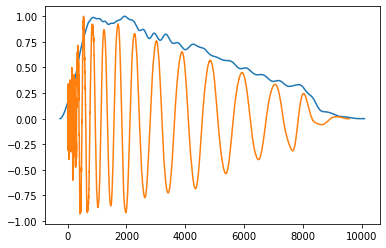

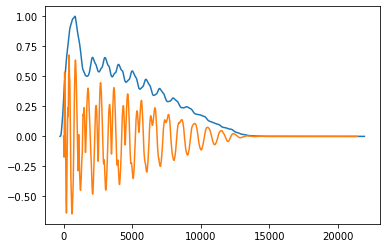

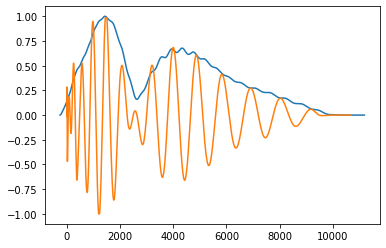

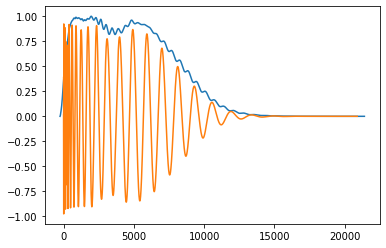

In [2]:
# def RMS(data):
#     return np.sqrt(np.mean(data**2))
from math import sqrt

def moving_rms(sample, n):
    ir = np.ones(n)/n
    return np.sqrt(np.convolve(sample**2, ir))

def moving_avg(sample, n):
    ir = np.ones(n)/n
    return np.convolve(sample, ir)

def plt_mvrms(sample):
    mv = moving_avg(moving_rms(sample, 512), 256)
    mv = mv * (1 / np.max(mv))
    plt.plot(range(-256, len(mv)-256), mv)
    plt.plot(sample)
    plt.show()


plt_mvrms(sample1[0][0])
plt_mvrms(sample2[0][0])
plt_mvrms(sample3[0][0])
plt_mvrms(sample4[0][0])

## Envelope Modelling: Peak Interpolation

Clearly, the windowed RMS doesn't work that well for this application. These samples produce a very wavy envelope even after smoothing.
Alternatively, we can take all the peaks of the wave and draw an envelope by interpolating through these peaks (e.g. linear or quadratic interpolation)


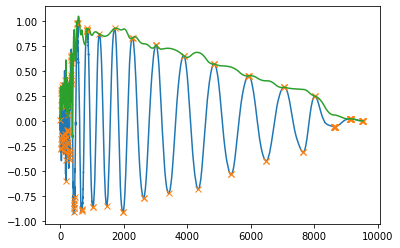

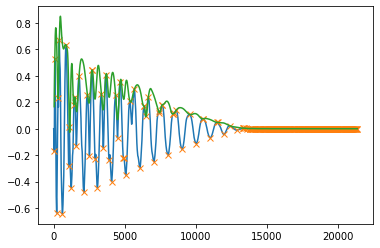

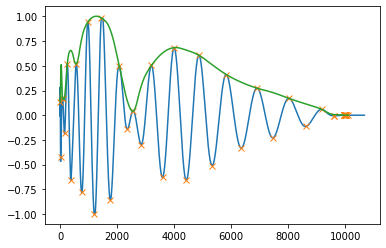

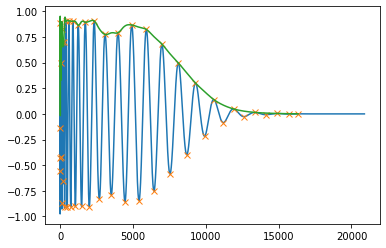

In [3]:
from scipy.signal import find_peaks
from scipy.interpolate import interp1d

def plt_pkin(sample):
    peaks, _ = find_peaks(moving_avg(np.abs(sample), 8))
    env = interp1d(peaks, np.abs(sample[peaks]), kind='quadratic', bounds_error=False)
    plt.plot(sample)
    plt.plot(peaks, sample[peaks], "x")
    xnew = range(0,len(sample))
#     mv = moving_avg(env(xnew), 512)
#     plt.plot(range(-512, len(mv) - 512), mv)
    plt.plot(xnew, env(xnew))
    plt.show()

plt_pkin(sample1[0][0])
plt_pkin(sample2[0][0])
plt_pkin(sample3[0][0])
plt_pkin(sample4[0][0])

## Envelope Modelling: Envelope Followers

The interpolation method worked better, but there are still cases of overfitting, for example with sample 2.
Another approach is to use an envelope follower. This keeps track of a state that increases and decreases at a slowed rate with respect to the input. Here it is important to pick the correct attack and release parameters for the application.

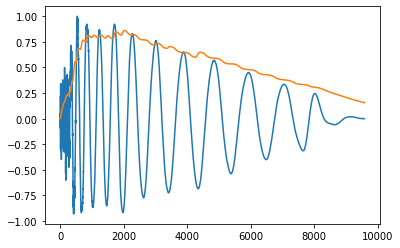

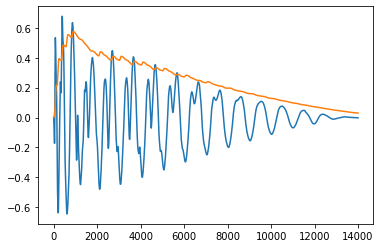

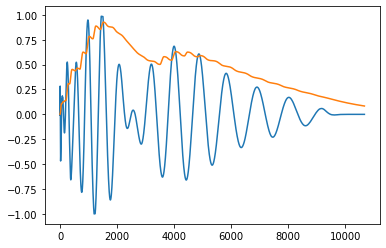

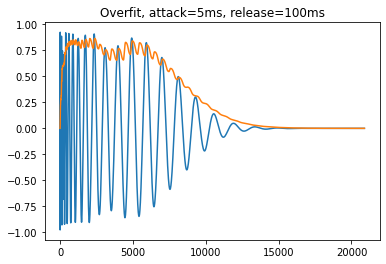

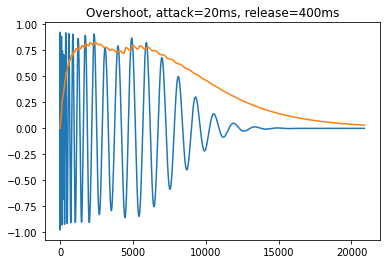

In [4]:
# algorithm from https://www.musicdsp.org/en/latest/Filters/265-output-limiter-using-envelope-follower-in-c.html
def env_follower(sample, attack, release, Fs=44100):
    a = pow(0.01, 1.0 / (attack * Fs * 0.001))
    r = pow(0.01, 1.0 / (release * Fs * 0.001))
    l = len(sample)
    state = 0.0
    env = np.empty(l)
    for i in range(0,l):
        v = abs(sample[i])
        if(v > state):
            state = a * (state - v) + v
        else:
            state = r * (state - v) + v
        env[i] = state
    return env

plt.plot(sample1[0][0])
plt.plot(env_follower(sample1[0][0], 10, 200))
plt.show()
plt.plot(sample2[0][0][0:14000])
plt.plot(env_follower(sample2[0][0][0:14000], 10, 200))
plt.show()
plt.plot(sample3[0][0])
plt.plot(env_follower(sample3[0][0], 10, 200))
plt.show()
plt.figure(figsize=plt.rcParams["figure.figsize"])
plt.plot(sample4[0][0])
plt.plot(env_follower(sample4[0][0], 5, 100))
tikzplotlib.clean_figure()
tikzplotlib.save("env_overfit.tex", axis_width='3.2in', axis_height='2.4in')
plt.title("Overfit, attack=5ms, release=100ms")
plt.show()
plt.figure(figsize=plt.rcParams["figure.figsize"])
plt.plot(sample4[0][0])
plt.plot(env_follower(sample4[0][0], 20, 400))
tikzplotlib.clean_figure()
tikzplotlib.save("env_overshoot.tex", axis_width='3.2in', axis_height='2.4in')
plt.title("Overshoot, attack=20ms, release=400ms")
plt.show()

We see that sample 2 gets a much better envelope, but now the dip in sample 3 is almost entirely missed.

## Envelope Modelling: Fitting to a curve

If we are to define a quality measure based on the envelope of a sample, we have to define something to compare it to. Here, fitting the data to a sigmoid curve as the "smoothest possible" decay envelope.

[0.967811144888401, 3223.0, -0.001]
1 0.967811144888401
[ 9.63551354e-01  5.66829010e+03 -5.54427076e-04]
0.002131544542427155


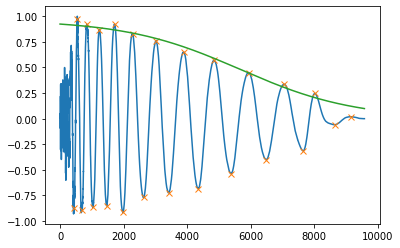

[0.6760083734989166, 5516.5, -0.001]
1 0.6760083734989166
[ 1.32787259e+02 -3.10107860e+04 -1.72857676e-04]
0.006490790953376297


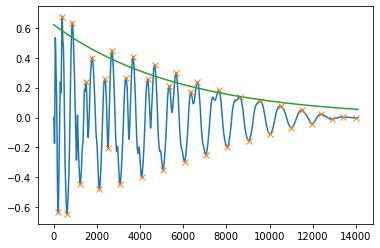

[0.9997958093881607, 3400.5, -0.001]
4 0.9474561959505081
[ 1.85966821e+03 -4.68369390e+04 -1.62721279e-04]
0.04871142426949166


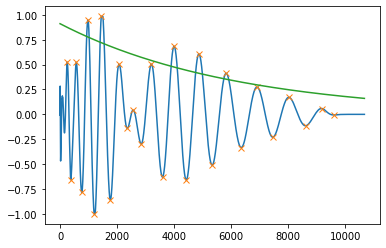

[0.9121148139238358, 5173.0, -0.001]
0 0.9121148139238358
[ 8.83022774e-01  8.48043700e+03 -8.17826397e-04]
0.000993367664684061


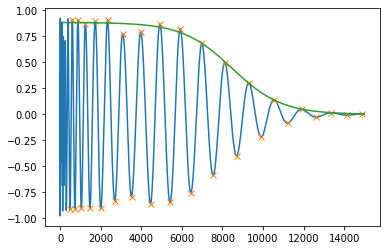

In [5]:
# Code inspired by https://stackoverflow.com/questions/55725139/fit-sigmoid-function-s-shape-curve-to-data-using-python?rq=1

from scipy.optimize import curve_fit

def sigmoid(x, L, x0, k):
    y = L / (1 + np.exp(-k*(x-x0)))
    return (y)

def env_fit(sample, ev=2500):
    #find peaks
    mv = moving_avg(np.abs(sample), 8)
    xpeaks, _ = find_peaks(mv, width=64, height=1e-3)
    ypeaks = np.abs(mv[xpeaks])
    #fit curve
    p0 = [max(ypeaks), np.median(xpeaks),-.001]
#     p0 = [max(ypeaks), len(sample)/2,-.001]
#     p0 = [max(ypeaks), np.max(xpeaks)/2,-.001]
    print(p0)
    fit_start = np.argmax(ypeaks[0:5])
    lbounds = [0, -np.inf, -5]
    ubounds = [1e05, len(sample), 0]
    print(fit_start, ypeaks[fit_start])
    popt, pcov = curve_fit(sigmoid, xpeaks[fit_start:], ypeaks[fit_start:], p0, method='dogbox', maxfev=ev, bounds=(lbounds,ubounds))
    print(popt)
    #compute mean squared error
    l = sigmoid(xpeaks[fit_start:], *popt)
    print(np.mean(np.square(l - ypeaks[fit_start:])))
    #plotting stuff
    x = range(0, len(sample))
    plt.plot(sample)
    plt.plot(xpeaks, sample[xpeaks], "x")
    plt.plot(x, sigmoid(x, *popt))
    plt.show()
    
env_fit(sample1[0][0])
env_fit(sample2[0][0][0:14100])
env_fit(sample3[0][0])
env_fit(sample4[0][0][0:15000])

In [ ]:
import os

env_pairs = []

def env_qual(sample):
    #find peaks
    mv = moving_avg(np.abs(sample), 8) #TODO: Replace this with a proper lowpass at ~2 kHz
    xpeaks, _ = find_peaks(mv, width=64, height=1e-3)
    ypeaks = np.abs(mv[xpeaks])
    #fit curve
#     p0 = [max(ypeaks), 0,-.001]
    p0 = [max(ypeaks), np.median(xpeaks),-.001]
    lbounds = [0, -np.inf, -5]
    ubounds = [1e05, len(sample), 0]
    fit_start = np.argmax(ypeaks[0:6])
    try:
        popt, pcov = curve_fit(sigmoid, xpeaks[fit_start:], ypeaks[fit_start:], p0, method='dogbox', maxfev=10000, bounds=(lbounds,ubounds))
    except:
        return 0
    #compute mean squared error
    l = sigmoid(xpeaks[fit_start:], *popt)
    return 1 - 10*np.mean(np.square(l - ypeaks[fit_start:]))

for file in os.listdir('AI Sampleset Kicks'):
    sample = torchaudio.load('AI Sampleset Kicks/'+file)[0][0]
    envq = env_qual(sample)
    env_pairs.append((file, envq))

In [15]:
plt.hist([x[1] for x in env_pairs])
plt.show()

NameError: name 'env_pairs' is not defined

In [ ]:
env_pairs.sort(reverse=True, key=lambda x : x[1])

for x,y in env_pairs:
    print(x,y)

In [ ]:
env_fit(torchaudio.load("AI Sampleset Kicks/spectra_kick_oneshot_soggy.wav")[0][0], ev=10000)
# print(env_qual(torchaudio.load("AI Sampleset Kicks/WDH_KICK088.wav")[0][0]))

In [ ]:
plt.plot(torchaudio.load("AI Sampleset Kicks/spectra_kick_oneshot_soggy.wav")[0][0])

### TODO: Alternative envelope modelled by exponential decay.
Some of the kicks display an exponential decay instead of a sigmoid decay, like a sample from an acoustic kick drum would. These should not get too low of an evaluation. In some cases they also cause problems with fitting a sigmoid curve.

### TODO: Modelling attack time.
Most of the deficiencies found by this algorithm right now is caused by the randomness of the peaks it finds in the noisy transient, and the fact that often the transient has a lower amplitude compared to the highest point of the sample. A solution could be to lowpass the sample first, and then only start fitting after the attack is done. Within some boundaries however, since if the attack takes half of the sample this is obviously bad. So maybe take `argmax(ypeaks[0:2000])` for the point at which to start fitting.

This way we separate the quality of the transient from that of the decay.

### TODO: Try different starting values
If finding a fit fails, try some different starting values to see if it does converge. For exponential decay, maybe the value of L should be way bigger than 1.

In [6]:
from scipy.signal import butter,lfilter

def butter_lp(data, cutoff, fs=44100, order=4):
    ncut = 2 * cutoff / fs
    b, a = butter(order, ncut, btype='low', analog = False)
    y = lfilter(b, a, data)
    return y

def env_fit_lp(sample, ev=2500, savefig=None):
    #find peaks
#     mv = moving_avg(np.abs(sample), 8)
    mv = butter_lp(sample, 750)
    xpeaks, _ = find_peaks(np.abs(mv), width=64, height=1e-3)
    ypeaks = np.abs(mv[xpeaks])
    #fit curve
    p0 = [max(ypeaks), np.median(xpeaks),-.001]
#     p0 = [max(ypeaks), len(sample)/2,-.001]
#     p0 = [max(ypeaks), np.max(xpeaks)/2,-.001]
    print(p0)
    fit_start = np.argmax(ypeaks[0:5])
    lbounds = [0, -np.inf, -5]
    ubounds = [1e05, len(sample), 0]
    print(fit_start, ypeaks[fit_start])
    popt, pcov = curve_fit(sigmoid, xpeaks[fit_start:], ypeaks[fit_start:], p0, method='dogbox', maxfev=ev, bounds=(lbounds,ubounds))
    print(popt)
    #compute mean squared error
    l = sigmoid(xpeaks[fit_start:], *popt)
    print(1 - 10*np.mean(np.square(l - ypeaks[fit_start:])))
    #plotting stuff
    x = range(0, len(sample))
    plt.figure(figsize=plt.rcParams["figure.figsize"])
    plt.plot(mv)
    plt.plot(xpeaks, mv[xpeaks], "x")
    plt.plot(x, sigmoid(x, *popt))
    if savefig is not None:
        tikzplotlib.clean_figure()
        tikzplotlib.save(savefig, axis_width='3.2in', axis_height='2.4in')
    plt.show()

[0.9721998445870489, 3244.0, -0.001]
1 0.9721998445870489
[ 9.67060252e-01  5.67121488e+03 -5.50997704e-04]
0.9785482357056312


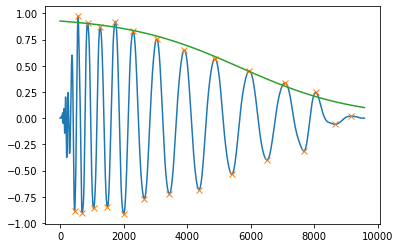

[0.6772566291911225, 5537.5, -0.001]
1 0.6772566291911225
[ 1.85534913e+03 -4.77618821e+04 -1.67742121e-04]
0.9351679994315172


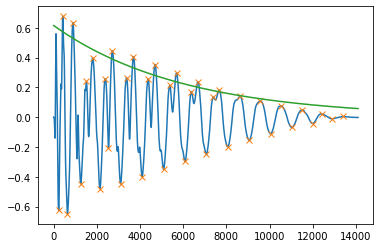

[1.0061474267091857, 3422.0, -0.001]
4 0.9478674260449198
[ 1.81226845e+03 -4.63403030e+04 -1.63720995e-04]
0.5097120371265378


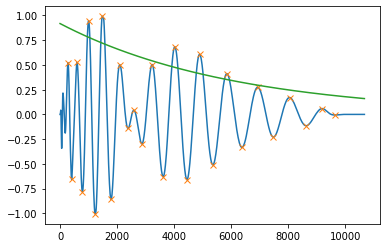

[0.9163840376707642, 5193.5, -0.001]
0 0.9163840376707642
[ 8.84007954e-01  8.49824979e+03 -8.15626389e-04]
0.9898831612701922


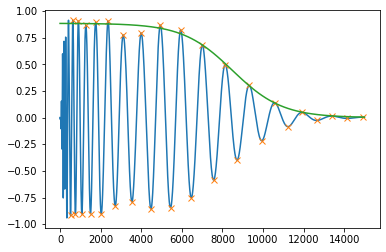

In [7]:
env_fit_lp(sample1[0][0])
env_fit_lp(sample2[0][0][0:14100])
env_fit_lp(sample3[0][0], savefig='sigmoid_bad.tex')
env_fit_lp(sample4[0][0][0:15000], savefig='sigmoid_good.tex')

In [24]:
def env_qual_lp(sample):
    #lowpass at 1000 Hz
    mv = butter_lp(sample, 1000)
    #find peaks
    xpeaks, _ = find_peaks(np.abs(mv), width=64, height=1e-3)
    ypeaks = np.abs(mv[xpeaks])
    #fit curve
#     p0 = [max(ypeaks), 0,-.001]
    p0 = [max(ypeaks), np.median(xpeaks),-.001]
    lbounds = [0, -np.inf, -5]
    ubounds = [1e05, len(sample), 0]
#     fit_start = np.argmax(ypeaks[0:5])
    fit_start = 0
    try:
        popt, _ = curve_fit(sigmoid, xpeaks[fit_start:], ypeaks[fit_start:], p0, method='dogbox', maxfev=10000, bounds=(lbounds,ubounds))
    except:
        return 0
    #compute mean squared error
    l = sigmoid(xpeaks[fit_start:], *popt)
    return np.mean(np.square(l - ypeaks[fit_start:]))

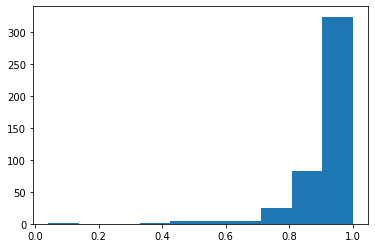

In [66]:
env_lp_pairs = []

for file in os.listdir('AI Sampleset Kicks'):
    sample = torchaudio.load('AI Sampleset Kicks/'+file)[0][0]
    envq = env_qual_lp(sample)
    env_lp_pairs.append((file, envq))

plt.hist([x[1] for x in env_lp_pairs])
plt.show()

spectra_kick_oneshot_bottleOpener.wav 0.1177770734507082
[0.9940183161539938, 1569.0, -0.001]
4 0.5293603155721194
[ 6.65421250e-01  4.31470710e+03 -2.93173831e-03]
0.42337390036605993


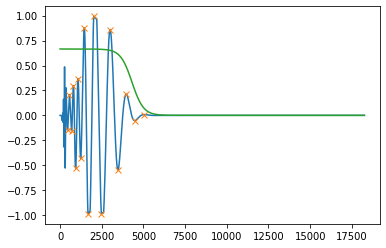

spectra_kick_oneshot_disorganized.wav 0.04242433810369928
[1.002133052412548, 3123.0, -0.001]
4 0.6872616982995352
[ 9.50457855e-01  5.18014319e+03 -5.24913760e-02]
0.9358784198319441


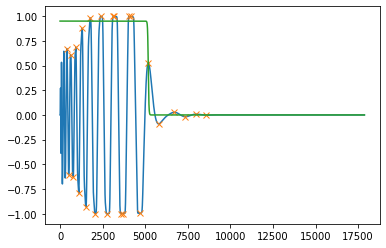

In [67]:
for x,y in env_lp_pairs:
    if(y < 0.25):
        print(x,y)
        s = torchaudio.load('AI Sampleset Kicks/'+x)[0][0]
        try:
            env_fit_lp(s, ev=100000)
        except:
            print("LP Exceeded")
            try:
                env_fit(s, ev=100000)
            except:
                print("MV Exceeded")

In [ ]:
env_max_pairs = []

for file in os.listdir('AI Sampleset Kicks'):
    sample = torchaudio.load('AI Sampleset Kicks/'+file)[0][0]
    envq = max(env_qual_lp(sample), env_qual(sample))
    env_max_pairs.append((file, envq))

plt.hist([x[1] for x in env_max_pairs])
plt.show()

In [ ]:
env_bad_pairs = []

for file in os.listdir('badkicks'):
    if(file.endswith(".wv")):
        continue
    sample = torchaudio.load('badkicks/'+file)[0][0]
    envq = max(env_qual_lp(sample), env_qual(sample))
    env_bad_pairs.append((file, envq))

plt.hist([x[1] for x in env_bad_pairs])
plt.show()

### Returning a value even if least squares does not converge

In [33]:
from scipy.optimize import least_squares

def sum_squares(popt, x, y):
    l = sigmoid(x, *popt)
    return (l - y)

def env_best(sample):
    #lowpass at 1000 Hz
    mv = butter_lp(sample, 1000)
    #find peaks
    xpeaks, _ = find_peaks(np.abs(mv), width=64, height=1e-3)
    ypeaks = np.abs(mv[xpeaks])
    #fit curve
    p0 = [max(ypeaks), np.median(xpeaks),-.001]
    lbounds = [0, -np.inf, -5]
    ubounds = [1e05, len(sample), 0]
#     try:
#         popt, _ = curve_fit(sigmoid, xpeaks, ypeaks, p0, method='dogbox', maxfev=10000, bounds=(lbounds,ubounds))
#     except:
#         return 0
    result = least_squares(sum_squares, p0, bounds=(lbounds,ubounds), method='dogbox', kwargs={'x': xpeaks, 'y': ypeaks}, max_nfev=10000)
    return 2 * result.cost / len(xpeaks)
#     return sum_squares(result["x"], xpeaks, ypeaks) / len(xpeaks)
#     popt = result.x
#     l = sigmoid(xpeaks, *popt)
#     return np.mean(np.square(l - ypeaks))

print(env_best(sample1[0][0]), env_qual_lp(sample1[0][0]))
print(env_best(sample2[0][0]), env_qual_lp(sample2[0][0]))
print(env_best(sample3[0][0]), env_qual_lp(sample3[0][0]))
print(env_best(sample4[0][0]), env_qual_lp(sample4[0][0]))
print(env_best(sample5[0][0]), env_qual_lp(sample5[0][0]))

0.0021173461561108373 0.0021173461561108373
0.006355261561138363 0.006355261561138362
0.04559614579332801 0.04559614579332801
0.0009840430132496945 0.0009840430132496945
0.001563901623344494 0.0015639016233444938


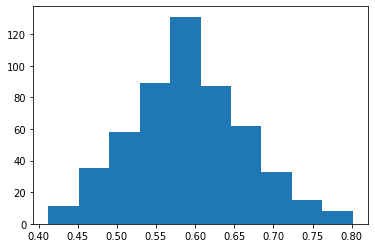

In [35]:
import sys
sys.path.append('quality')
from librosa.effects import trim
from quality.utils import butter_hp

def normalize(sample):
    return sample / np.max(sample)

def rms_qual(sample):
    """Quality based on the total RMS value of the sample. """
    rms = np.sqrt(np.mean(sample**2))
    return 1 - rms #rms = 1 is the "optimal" rms (which would be a square wave)

import os

rqs = []

for file in os.listdir('../sampleset/full/'):
    sample = torchaudio.load('../sampleset/full/'+file)[0][0].numpy()
    sample = normalize(butter_hp(trim(sample, top_db=36)[0],10))
    rq = rms_qual(sample)
    rqs.append((file, rq))

plt.hist(list(map(lambda x : x[1], rqs)))
plt.show()

In [36]:
for f,q in rqs:
    if q > 0.75:
        print(f,q)

3 Mr. Bill Kick.wav 0.7694713696790458
5 Mr. Bill Kick.wav 0.8014463178867289
B808M - Transistor Kicks 21.wav 0.7618516454622943
Kick Alessya DS 2.wav 0.7630148083549344
TT_Kick_31.wav 0.7569867845558654
TT_Kick_37.wav 0.7935096881914412
TT_Kick_38.wav 0.769522547215152
TT_Kick_39.wav 0.7664576948990149
wa_evolve_kick_91.wav 0.7635071988187222
WDH_KICK080.wav 0.7578185926091672
WDH_KICK081.wav 0.7649413087387567


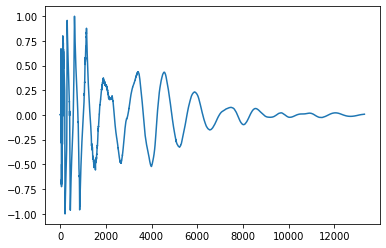

In [38]:
plt.plot(normalize(butter_hp(trim(torchaudio.load('../sampleset/full/wa_evolve_kick_91.wav')[0][0].numpy(), top_db=36)[0],10)))
plt.show()